
# Feature Extraction with DINO ViT-S/14

This notebook demonstrates how to perform feature extraction using the DINO ViT-S/14 model. We'll process an image, extract its features, and visualize these features using PCA.


In [ ]:
!pip install plotly

In [1]:

import torch
from PIL import Image
import torchvision.transforms as T
import hubconf
import matplotlib.pyplot as plt
import numpy as np



## Load the DINO ViT-S/14 Model

First, we load the DINO ViT-S/14 model using a pre-defined hub configuration.


In [2]:

dinov2_vitx14 = hubconf.dinov2_vitl14()


# Move the model to CUDA device
dinov2_vitx14 = dinov2_vitx14.to('cuda')

A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "C:\Users\withanda\AppData\Local\miniconda3\envs\dinov2\lib\site-packages\xformers\__init__.py", line 55, in _is_triton_available
    from xformers.triton.softmax import softmax as triton_softmax  # noqa
  File "C:\Users\withanda\AppData\Local\miniconda3\envs\dinov2\lib\site-packages\xformers\triton\softmax.py", line 11, in <module>
    import triton
ModuleNotFoundError: No module named 'triton'
D:\GitHub\dinov2\dinov2\layers\swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
D:\GitHub\dinov2\dinov2\layers\attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
D:\GitHub\dinov2\dinov2\layers\block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")



## Image Preprocessing

We load an image, perform necessary transformations, and prepare it for feature extraction.


- determine the dimensions of your image and the number of patches across its width and height. For example, if your image size is 224x224 and each patch is 16x16, the image will be divided into 14x14 patches (since 224/16=14).6=14).

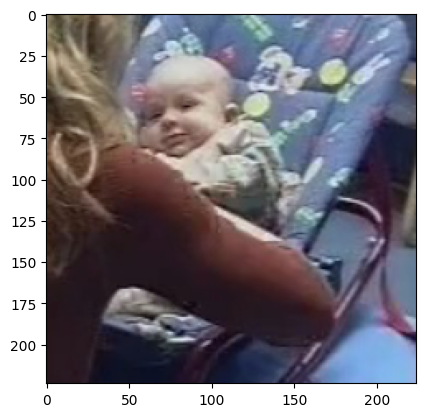

In [3]:
def imshow_normalized(img_tensor):
    # Convert the tensor to numpy
    img = img_tensor.numpy()
    
    # tensor [C, H, W], to change [H, W, C] 
    img = np.transpose(img, (1, 2, 0))
    
    # Since the range may not be [0, 1], we normalize it to [0, 1] for displaying.
    # This does not "denormalize" it to original pixel values, but makes it possible to display.
    img = (img - img.min()) / (img.max() - img.min())
    
    plt.imshow(img)
    plt.show() 
    
transforms = T.Compose([
    T.Resize(256),  # Resize the image to 256x256
    T.CenterCrop(224),  # Crop the image to 224x224
    T.ToTensor(),  # Convert the image to a PyTorch tensor
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet mean and std
])


img_ori = Image.open('D:/GitHub/dino/data/output/NP001/infant/frames/frame_0000.jpg')
#img = Image.open('D:\GitHub\dinov2\scripts\data\meta_dog.png')
plt.imshow(img_ori)
img_tran = transforms(img_ori)[:3]
img = transforms(img_ori)[:3].unsqueeze(0)

imshow_normalized(img_tran)
            


## Feature Extraction

Extract features from the image using the DINO ViT-S/14 model.


- feat_dim = 384  vits14- 
feat_dim = 76 for  vitb1
- 
feat_dim = 102# vitl
- 4
feat_dim = 156 # vitg14

In [4]:

with torch.no_grad():
    inference = dinov2_vitx14.forward_features(img.to('cuda'))

print(inference.keys())


dict_keys(['x_norm_clstoken', 'x_norm_regtokens', 'x_norm_patchtokens', 'x_prenorm', 'masks'])


In [5]:
features_rank = dinov2_vitx14(img.to('cuda')).float()
features_rank.shape[-1]

1024

In [6]:
 inference['x_norm_patchtokens'].shape

torch.Size([1, 256, 1024])

In [7]:
# create a numpy array 
tensor_detached_features = inference['x_norm_patchtokens'].detach() 
if tensor_detached_features.is_cuda:
    tensor_features = tensor_detached_features.cpu()  # Moves the tensor to CPU if it's on GPU

features = tensor_features.numpy()[0]
features.shape

(256, 1024)

# Visualise first and last 10 features before PCA


- Normalize each of the first 10 features across all patches

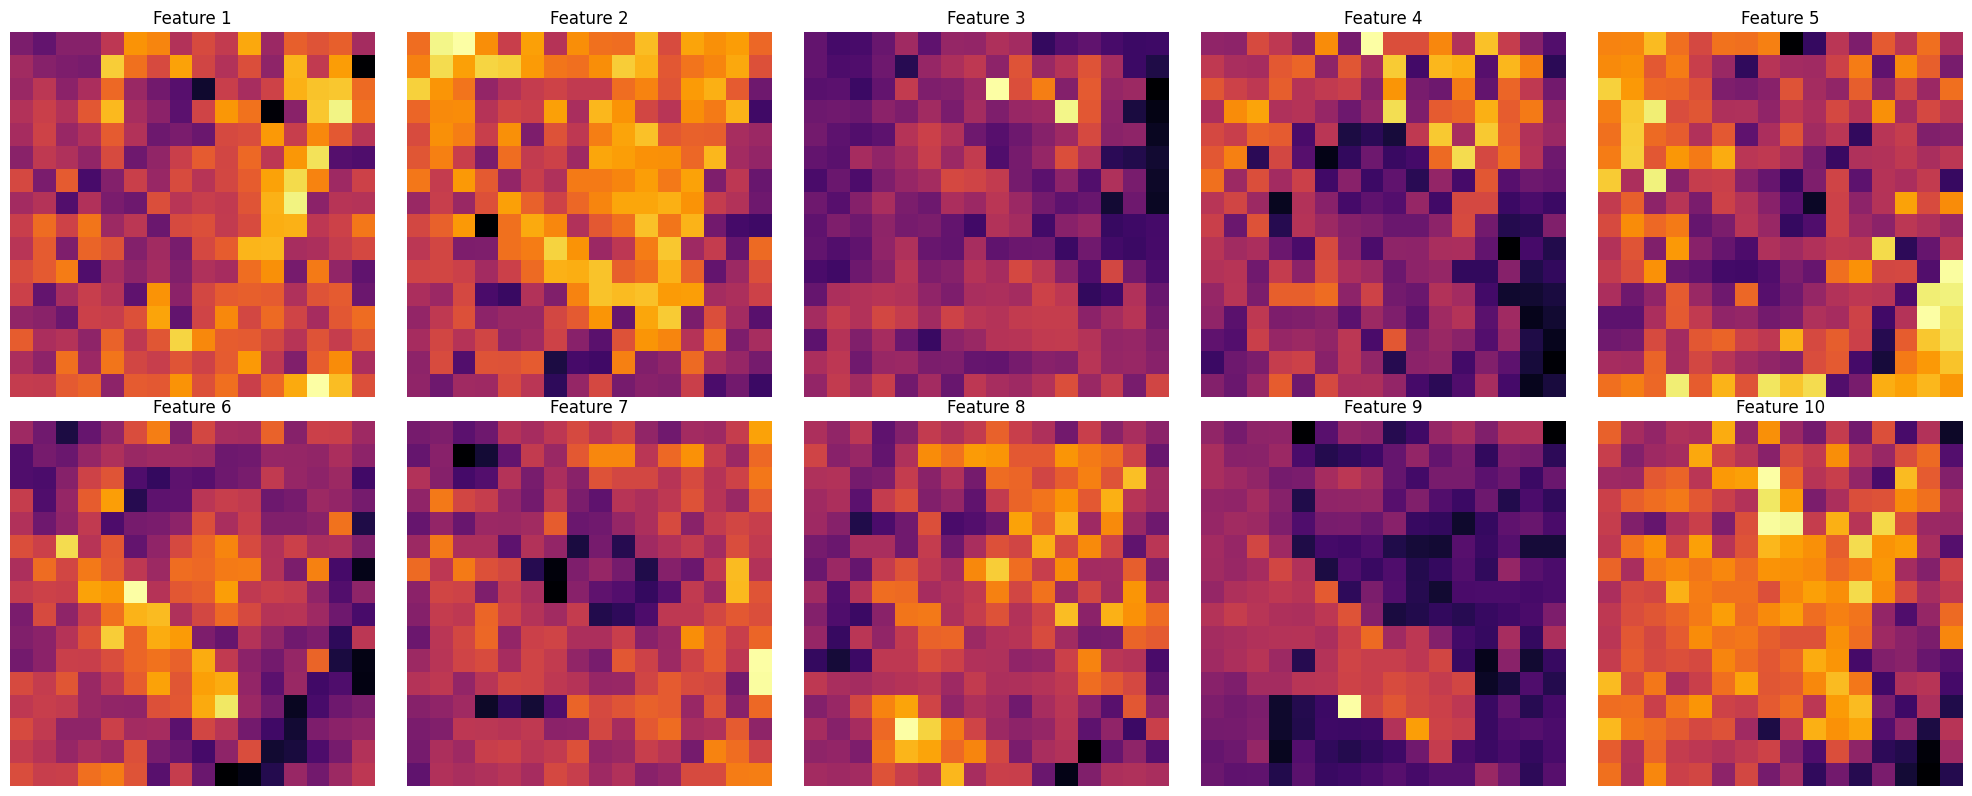

In [8]:
normalized_features = np.empty((256, 10))
for i in range(10): 
    min_feat = np.min(features[:, i])
    max_feat = np.max(features[:, i])
    normalized_features[:, i] = (features[:, i] - min_feat) / (max_feat - min_feat) * 255

fig, axes = plt.subplots(2, 5, figsize=(20, 8))  
axes = axes.flatten()  

for i, ax in enumerate(axes):
    # Treat each feature value as one patch/token and reshape the 256 patches into a 16*16 grid
    # TODO: should not this be 14*14 grid? 
    feature_image = normalized_features[:, i].reshape(16, 16)
    ax.imshow(feature_image.astype(np.uint8), cmap='inferno')
    ax.set_title(f'Feature {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()


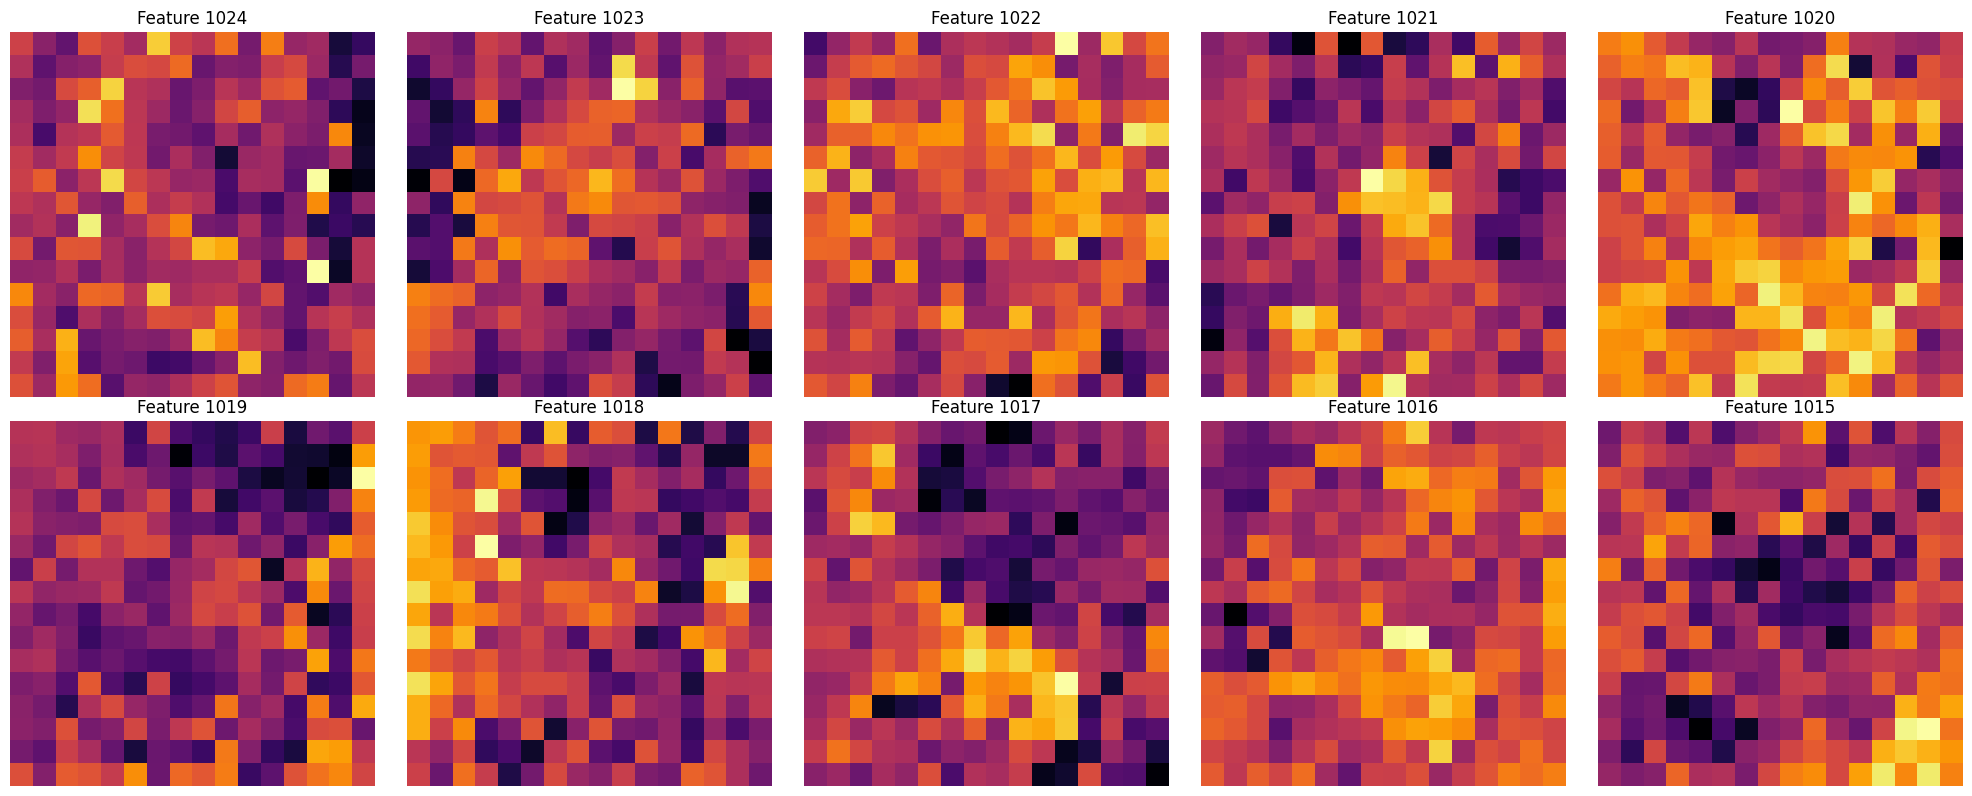

In [9]:
#
normalized_features_last = np.empty((256, 10))
for i in range(1, 11):  # Loop over the last 10 features
    min_feat = np.min(features[:, -i])
    max_feat = np.max(features[:, -i])
    normalized_features_last[:, -i] = (features[:, -i] - min_feat) / (max_feat - min_feat) * 255

# Visualize each of the last 10 features
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # Adjusted for 10 features
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i, ax in enumerate(axes):
    # Treat each feature value as one patch/token and reshape the 256 patches into a 16x16 grid
    feature_image = normalized_features_last[:, -i-1].reshape(16, 16)  # Adjust index for correct visualization order
    ax.imshow(feature_image.astype(np.uint8), cmap='inferno')
    ax.set_title(f'Feature {1024 - i}')
    ax.axis('off')

plt.tight_layout()
plt.show()



## Feature Visualization

We apply PCA to the extracted features and visualize the result.


High-Dimensional Feature Space
Context: Each of the 256 patches (or tokens) from the attention map is represented by afeat_dim = 384 # vits14
feat_dim = 768 # vitb14
feat_dim = 1024 # vitl14
feat_dim = 1536 # vitg144-dimensional feature vector, capturing complex information but challenging to directly analyze or visualize.

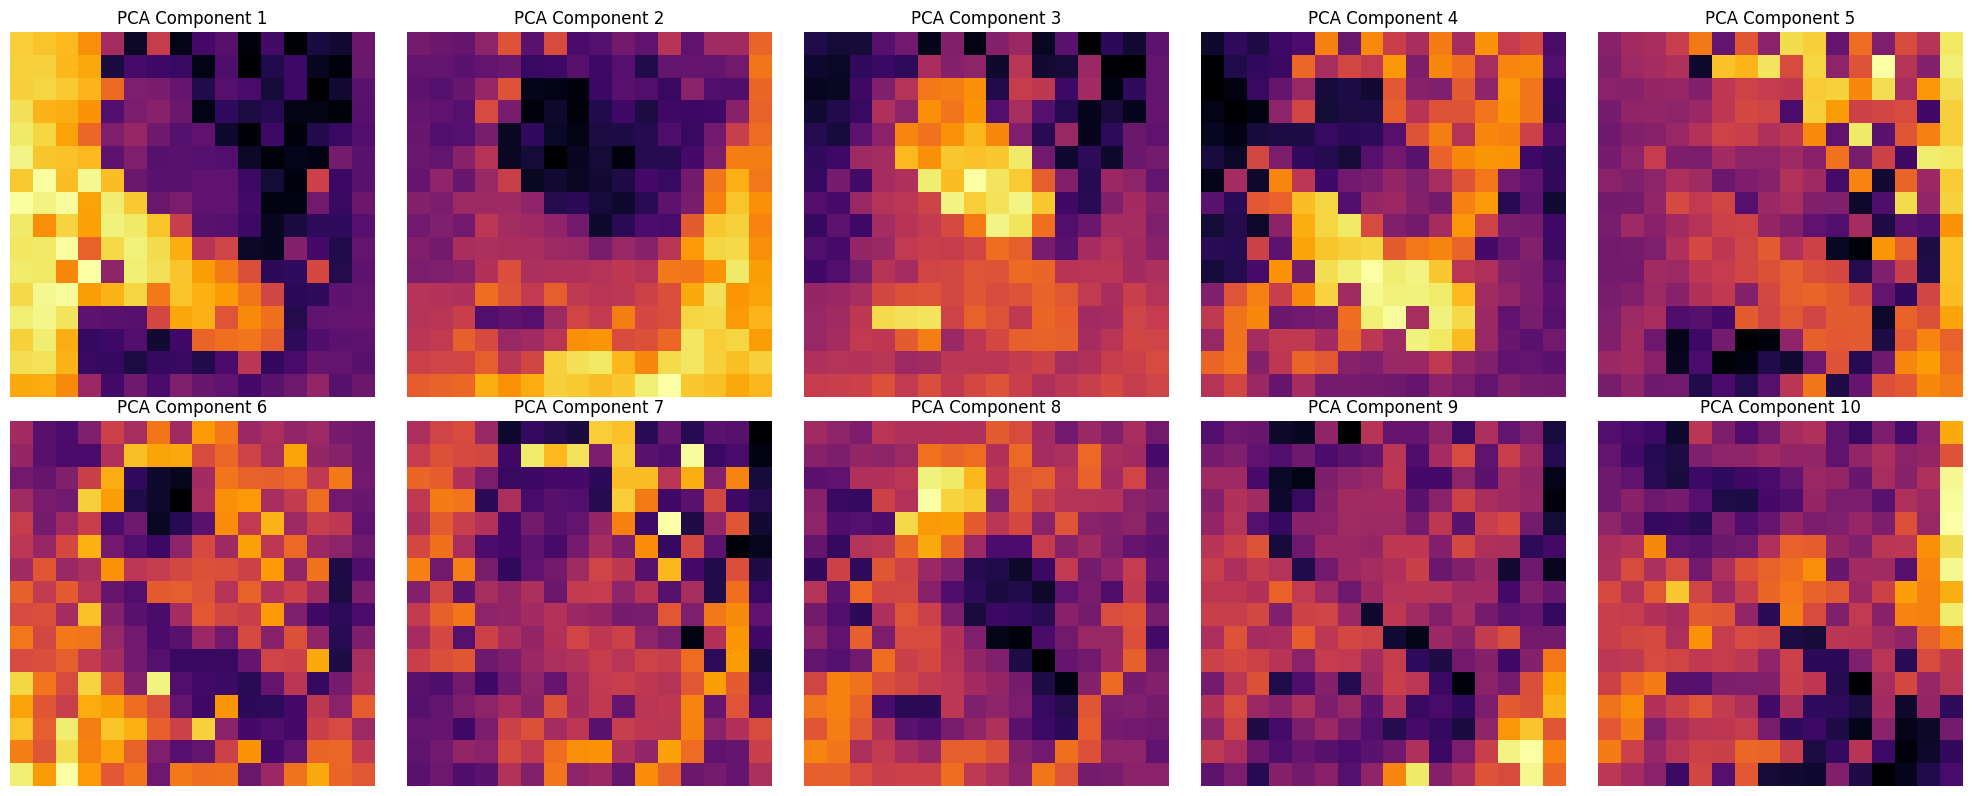

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca_features = pca.fit_transform(features)

pca_features_normalized = np.empty_like(pca_features)
for i in range(pca_features.shape[1]):
    component = pca_features[:, i]
    pca_features_normalized[:, i] = (component - component.min()) / (component.max() - component.min())

pca_features_normalized *= 255


fig, axes = plt.subplots(2, 5, figsize=(20, 8))  
axes = axes.flatten()  

for i, ax in enumerate(axes):
    component_image = pca_features_normalized[:, i].reshape(16, 16)
    ax.imshow(component_image.astype(np.uint8), cmap='inferno')
    ax.set_title(f'PCA Component {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()


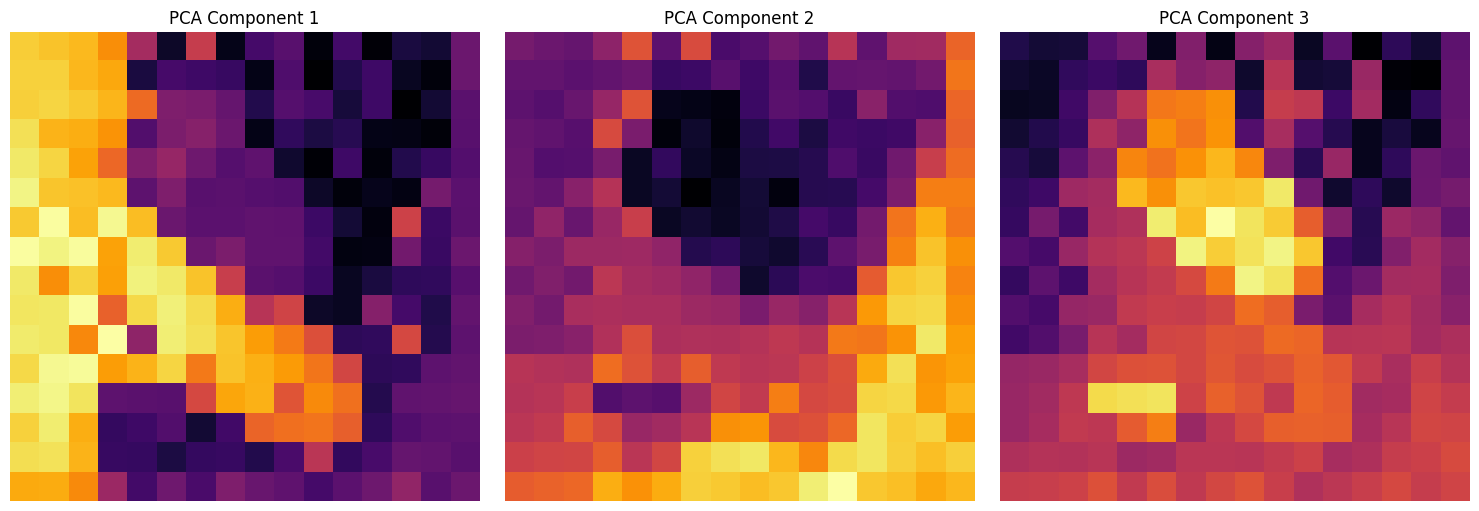

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Assuming `features` is your input array of shape (256, 1024)

# Apply PCA
pca = PCA(n_components=3)
pca_features = pca.fit_transform(features)  # Shape: (256, 3)

# Normalize PCA features for visualization
# Normalize each component separately to use the full color range for each
pca_features_normalized = np.empty_like(pca_features)
for i in range(pca_features.shape[1]):  # Loop over each component
    component = pca_features[:, i]
    pca_features_normalized[:, i] = (component - component.min()) / (component.max() - component.min())

# Reshape and scale for visualization
pca_features_normalized *= 255

# Visualize each PCA component
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    # Reshape the i-th component to 16x16 for visualization
    component_image = pca_features_normalized[:, i].reshape(16, 16)
    ax.imshow(component_image.astype(np.uint8), cmap='inferno')
    ax.set_title(f'PCA Component {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()


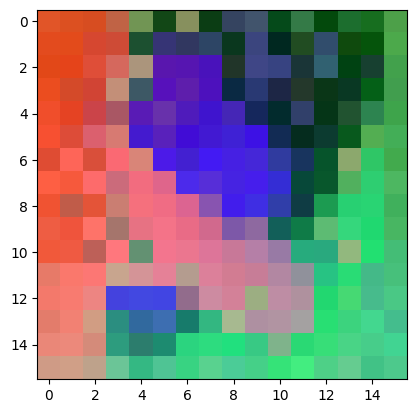

In [12]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA


pca = PCA(n_components=3)
pca.fit(features)
pca_features = pca.transform(features)
pca_features = (pca_features - pca_features.min()) / (pca_features.max() - pca_features.min())
pca_features = pca_features * 255

plt.imshow(pca_features.reshape(16, 16, 3).astype(np.uint8))
#plt.savefig('meta_dog_features.png')


# Visualize the Explained Variance

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


pca = PCA(n_components=256)

pca.fit(features)


plt.figure(figsize=(8, 5))
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('PCA Explained Variance')
plt.xticks(range(1, pca.n_components_ + 1))
plt.show()


In [ ]:
print(pca.n_features_in_)
print(pca.n_components_)

## Before and after normalizing

In [ ]:
plt.figure(figsize=(12, 6))

# Before normalization
plt.subplot(1, 2, 1)
plt.hist(pca_features.flatten(), bins=50, color='blue', alpha=0.5)
plt.title('Histogram of PCA Features Before Normalization')

pca_features_normalized = (pca_features - pca_features.min()) / (pca_features.max() - pca_features.min())
pca_features_normalized *= 255

plt.subplot(1, 2, 2)
plt.hist(pca_features_normalized.flatten(), bins=50, color='green', alpha=0.5)
plt.title('Histogram of PCA Features After Normalization')

plt.show()


# PCA feature visualization

In [ ]:
pca = PCA(n_components=3)
pca.fit(features)
pca_features = pca.transform(features)

if pca.n_components_ == 3:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pca_features_normalized[:,0], pca_features_normalized[:,1], pca_features_normalized[:,2])
    ax.set_title('3D Scatter plot of PCA Features')
    plt.show()
elif pca.n_components_ == 2:
    plt.scatter(pca_features_normalized[:,0], pca_features_normalized[:,1])
    plt.title('2D Scatter plot of PCA Features')
    plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=3)
pca.fit(features)
pca_features = pca.transform(features)

pca_features_normalized = (pca_features - np.min(pca_features, axis=0)) / (np.max(pca_features, axis=0) - np.min(pca_features, axis=0))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = pca_features_normalized
ax.scatter(pca_features_normalized[:,0], pca_features_normalized[:,1], pca_features_normalized[:,2], c=colors)

ax.set_title('3D Scatter plot of PCA Features')
plt.show()


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

color_values = pca_features[:,2] 
color_values_normalized = (color_values - np.min(color_values)) / (np.max(color_values) - np.min(color_values))
colors = plt.cm.jet(color_values_normalized) 


plt.scatter(pca_features[:,0], pca_features[:,1], color=colors)
plt.title('2D Scatter plot of PCA Features')
plt.colorbar()
plt.show()


In [ ]:
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
import plotly.io as pio
pio.renderers.default = 'notebook'


init_notebook_mode(connected=True)

fig = go.Figure(data=[go.Scatter3d(
    x=pca_features_normalized[:, 0],
    y=pca_features_normalized[:, 1],
    z=pca_features_normalized[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=np.arange(len(pca_features_normalized)),
        colorscale='Viridis', 
        opacity=0.8,
        colorbar=dict(title='Point Index')
    )
)])

print(pca_features_normalized.shape)

fig.update_layout(
    title='3D Scatter plot of PCA Features',
    scene=dict(
        xaxis_title='PCA 1',
        yaxis_title='PCA 2',
        zaxis_title='PCA 3'
    ),
    margin=dict(l=0, r=0, b=0, t=0) 
)

fig.show()
